<a href="https://colab.research.google.com/github/Oleksij-gh/PersonaFilmRecommender/blob/main/RecSysBinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://grouplens.org/datasets/movielens/tag-genome-2021/

Global parameters

In [1]:
seed = 42

to do:

Значения характера - категориальные признаки и прогнать через OHE

# Data

## Donload and Unzip

In [2]:
import zipfile

In [3]:
!gdown 1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF


Downloading...
From: https://drive.google.com/uc?id=1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF
To: /content/RecSys.zip
100% 9.92M/9.92M [00:00<00:00, 94.8MB/s]


In [4]:
with zipfile.ZipFile('/content/RecSys.zip') as zip:
    zip.extractall('/content/data')

In [5]:
!wget https://files.grouplens.org/datasets/tag-genome-2021/genome_2021.zip

--2024-05-10 19:40:19--  https://files.grouplens.org/datasets/tag-genome-2021/genome_2021.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928028583 (1.8G) [application/zip]
Saving to: ‘genome_2021.zip.1’

genome_2021.zip.1   100%[===================>]   1.79G  44.0MB/s    in 32s     

2024-05-10 19:40:51 (58.3 MB/s) - ‘genome_2021.zip.1’ saved [1928028583/1928028583]



In [6]:
with zipfile.ZipFile('/content/genome_2021.zip') as zip:
    zip.extractall('/content/data')

## Preprocessing

In [7]:
import pandas as pd

### Personality

In [45]:
person_data = pd.read_csv('/content/data/2018-personality-data.csv')
rating_data = pd.read_csv('/content/data/2018_ratings.csv')

In [46]:
person_data = person_data.drop([' assigned metric',
       ' assigned condition', ' movie_1', ' predicted_rating_1', ' movie_2',
       ' predicted_rating_2', ' movie_3', ' predicted_rating_3', ' movie_4',
       ' predicted_rating_4', ' movie_5', ' predicted_rating_5', ' movie_6',
       ' predicted_rating_6', ' movie_7', ' predicted_rating_7', ' movie_8',
       ' predicted_rating_8', ' movie_9', ' predicted_rating_9', ' movie_10',
       ' predicted_rating_10', ' movie_11', ' predicted_rating_11',
       ' movie_12', ' predicted_rating_12', ' is_personalized',
       ' enjoy_watching '], axis=1)

In [47]:
person_data.rename({' openness': 'openness',
                    ' agreeableness': 'agreeableness',
                    ' emotional_stability': 'emotional_stability',
                    ' conscientiousness': 'conscientiousness',
                    ' extraversion': 'extraversion',
                    }, inplace=True, axis=1)

In [48]:
rating_data.rename({'useri': 'userid',
                    ' rating': 'rating',
                    ' movie_id': 'movie_id'}, inplace=True, axis=1)

In [49]:
df_personality = person_data.merge(rating_data, how="inner", on=['userid'])

In [50]:
df_personality = df_personality.drop([' tstamp '], axis=1)

In [51]:
df_personality['rating'].astype('int').value_counts()

rating
3    416879
4    348024
2    158296
5     72821
1     52546
0     21637
Name: count, dtype: int64

<Axes: >

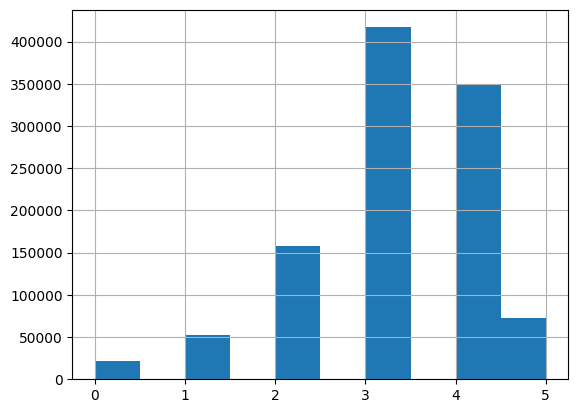

In [52]:
df_personality['rating'].astype('int').hist()

### Movies

In [53]:
import json

In [54]:
def GetJsonDf(path):
  json_list = [json.loads(line) for line in open(path, 'r')]
  json_str = json.dumps(json_list)
  df = pd.read_json(json_str)
  return df

Metadata

In [55]:
df_metadata = GetJsonDf('/content/data/movie_dataset_public_final/raw/metadata.json')

In [56]:
df_metadata.rename({'item_id': 'movie_id'}, inplace=True, axis=1)

Tags

In [57]:
df_survey = GetJsonDf('/content/data/movie_dataset_public_final/raw/survey_answers.json')

In [58]:
df_survey.rename({'item_id': 'movie_id'}, inplace=True, axis=1)

In [59]:
df_tags = GetJsonDf('/content/data/movie_dataset_public_final/raw/tags.json')

In [60]:
df_tags.rename({'id': 'tag_id'}, inplace=True, axis=1)

In [61]:
res = (df_survey.groupby(['movie_id'], as_index=False).apply(lambda x: x.nlargest(3,['score'])).reset_index(level=0, drop=True))

In [62]:
res = res.merge(df_tags, how="left", on=['tag_id'])

In [63]:
tags = {}
for i, row in res.iterrows():
  try:
    tags[row['movie_id']].append(row['tag'])
  except:
    tags[row['movie_id']] = [row['tag']]



In [64]:
tag_count_df = GetJsonDf('/content/data/movie_dataset_public_final/raw/tag_count.json')

In [ ]:
#reviews_df = GetJsonDf('/content/data/movie_dataset_public_final/raw/reviews.json') # вышибает по памяти

### Merge

In [65]:
df_merge = df_personality.merge(df_metadata, how="left", on=['movie_id'])

In [66]:
def GetTag(movie_id, num, tags):
  try:
    return tags[movie_id][num-1]
  except:
    return None

In [67]:
for i in range(3):
  df_merge['tag'+str(i+1)] = df_merge['movie_id'].apply(lambda x: GetTag(x, i, tags))

In [68]:
df_merge.drop(['dateAdded', 'avgRating', 'imdbId', 'movie_id'], inplace=True, axis=1)

In [171]:
# TEST TEST TEST TEST
df_merge.drop(['directedBy', 'starring'], inplace=True, axis=1)

In [69]:
df_merge.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,rating,title,directedBy,starring,tag1,tag2,tag3
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,5.0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",animation,pixar,comedy
1,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,4.0,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",animation,animals,animals
2,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,4.0,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",minnesota,sequel,minnesota
3,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,5.0,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",pregnancy,good sequel,comedy
4,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,4.0,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...",action,crime,dialogue


# Split

In [70]:
df = df_merge.copy()

In [71]:
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [72]:
categorical_columns = ['openness', 'agreeableness', 'emotional_stability', 'conscientiousness', 'extraversion']
for column in categorical_columns:
  df[column] = df[column].astype(object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# OneHotEncoder

#categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
#encoder = OneHotEncoder(sparse_output=False)
#encoder = encoder.fit(df[categorical_columns])
#ohe = encoder.transform(df[categorical_columns])
#ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(categorical_columns))
#df = pd.concat([df, ohe_df], axis=1)
#df = df.drop(categorical_columns, axis=1)

In [73]:
X = df.drop('rating', axis = 1)#.values.astype('float32')
y = df['rating'].values.astype('int')

In [75]:
!pip install category_encoders --quiet
import category_encoders as ce

In [76]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(X, y)
X_cbe = cbe_encoder.transform(X)

In [77]:
X = X_cbe.values.astype('float32')

UnderSampling

In [138]:
#from imblearn.under_sampling import RandomUnderSampler
#
#rus = RandomUnderSampler(random_state=seed)
#
#X, y = rus.fit_resample(X, y)

# NN

## Split data

In [78]:
from sklearn.model_selection import train_test_split

def split_data(X, y, seed=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed, stratify=y_train)

  return X_train, y_train, X_val, y_val, X_test, y_test

## Pytorch

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import copy
import numpy as np

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [80]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [81]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [82]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(y)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Define train dataloader

In [83]:
train_data = Data(X_train, y_train)
train_dl = DataLoader(dataset=train_data, batch_size=32)

Define validate data

In [84]:
val_data = Data(X_val, y_val)
valid_dl = DataLoader(dataset=val_data, batch_size=32)

Define test data

In [85]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test


In [86]:
class Model(nn.Module):

    def __init__(self, input_shape, output_shape=2):
      super(Model, self).__init__()

      self.normalize = nn.BatchNorm1d(input_shape)

      self.fc1 = nn.Linear(input_shape, 32)
      self.fc2 = nn.Linear(32, 64)
      self.fc3 = nn.Linear(64, 128)
      self.fc4 = nn.Linear(128, 256)
      self.dropout = nn.Dropout(p=0.1)
      self.fc5 = nn.Linear(256, 128)
      self.fc6 = nn.Linear(128, 64)
      self.fc7 = nn.Linear(64, output_shape)

    def forward(self, x):
      x = self.normalize(x)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = self.dropout(x)
      x = F.relu(self.fc5(x))
      x = F.relu(self.fc6(x))
      x = self.fc7(x)

      return x


In [89]:
# training parameters
n_epochs = 5
learning_rate = 1e-2

model = Model(X_train.shape[1], len(set(y)))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()



# Hold the best model
best_loss = np.inf
best_weights = None

# save history
history_loss = []
history_f1 = []
history_acc = []
history_val_loss = []
history_val_f1 = []
history_val_acc = []

total_params = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params count: {params_trainable }')
print(f'Total params count: {total_params}')

Trainable params count: 85178
Total params count: 85178


In [90]:
from sklearn.metrics import f1_score, accuracy_score

In [91]:
# training loop
for epoch in range(n_epochs):
  print(f'Epoch {epoch}')
  model.train()
  for X_train, y_train in tqdm(train_dl):

    # forward pass
    y_pred = model(X_train)

    # calculate loss
    loss = criterion(y_pred, y_train)
    writer.add_scalar("Loss/train", loss, epoch)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

  # calculate score
  _, y_pred = torch.max(y_pred.data, 1)
  y_pred = y_pred.cpu().numpy()

  f1 = f1_score(y_train, y_pred)
  acc = accuracy_score(y_train, y_pred)

  history_f1.append(f1)
  history_acc.append(acc)

  print(f'Train Loss: {loss:.3f} | F1: {f1:.3f} | Accuracy: {acc:.3f}')
  history_loss.append(float(loss))

  # evaluate
  model.eval()
  loss_val = 0
  acc_val = 0
  f1_val = 0

  with torch.no_grad():
    for X_val, y_val in valid_dl:
      y_pred = model(X_val)
      loss_val += criterion(y_pred, y_val)

      _, y_pred = torch.max(y_pred.data, 1)
      y_pred = y_pred.cpu().numpy()

      f1 = f1_score(y_val, y_pred)
      acc = accuracy_score(y_val, y_pred)

      acc_val += acc
      f1_val += f1

    # calculate valid loss, acc
    loss_val /= len(valid_dl)
    acc_val /= len(valid_dl)
    f1_val /= len(valid_dl)

    history_val_loss.append(loss_val)
    history_val_acc.append(acc_val)
    history_val_f1.append(f1_val)

    print(f'Validate Loss: {loss_val:.3f} | F1: {f1_val:.3f} | Accuracy: {acc_val:.3f}')
    print('-'*30)

    # store best model
    if loss_val < best_loss:
      best_loss = loss_val
      best_model_wts = copy.deepcopy(model.state_dict())
writer.flush()

Epoch 0


100%|██████████| 20067/20067 [02:24<00:00, 139.01it/s]


Train Loss: 0.590 | F1: 0.571 | Accuracy: 0.667
Validate Loss: 0.512 | F1: 0.661 | Accuracy: 0.745
------------------------------
Epoch 1


100%|██████████| 20067/20067 [02:12<00:00, 150.98it/s]


Train Loss: 0.606 | F1: 0.750 | Accuracy: 0.778
Validate Loss: 0.516 | F1: 0.681 | Accuracy: 0.735
------------------------------
Epoch 2


100%|██████████| 20067/20067 [02:40<00:00, 125.10it/s]


Train Loss: 0.619 | F1: 0.750 | Accuracy: 0.778
Validate Loss: 0.519 | F1: 0.675 | Accuracy: 0.741
------------------------------
Epoch 3


100%|██████████| 20067/20067 [03:34<00:00, 93.74it/s]


Train Loss: 0.636 | F1: 0.750 | Accuracy: 0.778
Validate Loss: 0.511 | F1: 0.656 | Accuracy: 0.745
------------------------------
Epoch 4


100%|██████████| 20067/20067 [03:49<00:00, 87.49it/s]


Train Loss: 0.673 | F1: 0.750 | Accuracy: 0.778
Validate Loss: 0.512 | F1: 0.656 | Accuracy: 0.745
------------------------------


In [93]:
from matplotlib import pyplot as plt

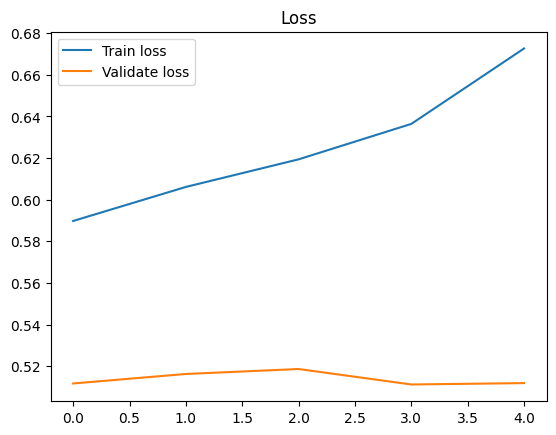

In [94]:
plt.plot(history_loss)
plt.plot(history_val_loss)
plt.legend(['Train loss', 'Validate loss'])
plt.title('Loss')
plt.show()


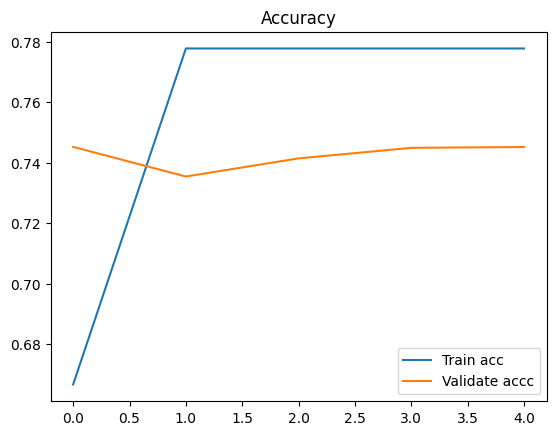

In [95]:
plt.plot(history_acc)
plt.plot(history_val_acc)
plt.legend(['Train acc', 'Validate accc'])
plt.title('Accuracy')
plt.show()


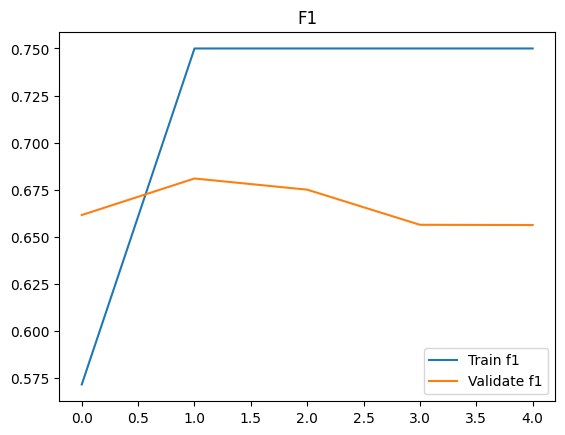

In [96]:
plt.plot(history_f1)
plt.plot(history_val_f1)
plt.legend(['Train f1', 'Validate f1'])
plt.title('F1')
plt.show()

In [97]:
model.load_state_dict(best_model_wts)
model.eval()
y_pred = model(X_test)
_, y_pred = torch.max(y_pred.data, 1)
y_pred = y_pred.cpu().numpy()

In [98]:
set(y_pred)

{0, 1}

In [99]:
print(y_pred)

[0 0 0 ... 0 1 1]


In [100]:
print(y_test)

[0 0 0 ... 0 1 0]


In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [102]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy = {accuracy}')
print(f'Precision = {precision}')
print(f'Recall = {recall}')
print(f'F1 = {f1}')

Accuracy = 0.7459925902046805
Precision = 0.6884016740633969
Recall = 0.6468533545604677
F1 = 0.6669810974041087


P@K
R@K
Метрики для оценки после выпуска в прод

# Tensorboard

In [214]:
!pip install tensorboard

In [ ]:
http://localhost:6006/

In [215]:
!tensorboard --logdir=runs

2024-05-10 11:16:35.988494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 11:16:35.988566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 11:16:35.991618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 11:16:39.811844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 